In [1]:
# %load ../jupyter_setup.txt
# Convenient jupyter setup
%load_ext autoreload
%load_ext line_profiler
%autoreload 2
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False 

In [5]:
import numpy as np
import geopandas as gpd
import shapely
from typing import Iterable, Tuple, Dict

import matplotlib.pyplot as plt
import seaborn as sns

from src.constants import SRC_PATH
from src.data_loading.rasterio_utils import polygonise
from src.data_loading.vector_utils import shapely_to_frame
from src.tests.utils import polygonise_sub_array, plot_identified_nodes, get_array_transform
from src.models.geograph import GeoGraph
from src.models.binary_graph_operations import identify_node, identify_node_old

In [6]:
TEST_DATA_FOLDER = SRC_PATH / "tests" / "testdata"
TEST_DATA_FOLDER.mkdir(parents=True, exist_ok=True)

In [7]:
full = GeoGraph(TEST_DATA_FOLDER / "overlapping" / "full.gpkg")
upper_right = GeoGraph(TEST_DATA_FOLDER / "overlapping" / "upper_right.gpkg")
upper_left = GeoGraph(TEST_DATA_FOLDER / "overlapping" / "upper_left.gpkg")
lower_right = GeoGraph(TEST_DATA_FOLDER / "overlapping" / "lower_right.gpkg")
lower_left = GeoGraph(TEST_DATA_FOLDER / "overlapping" / "lower_left.gpkg")

/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 9/9 [00:00<00:00, 495.78it/s]
Step 2 of 2: Adding edges: 100%|██████████| 9/9 [00:00<00:00, 22563.50it/s]


Graph successfully loaded with 9 nodes and 19 edges.


Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 5/5 [00:00<00:00, 1160.89it/s]
Step 2 of 2: Adding edges: 100%|██████████| 5/5 [00:00<00:00, 5574.57it/s]


Graph successfully loaded with 5 nodes and 6 edges.


Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 7/7 [00:00<00:00, 2220.72it/s]
Step 2 of 2: Adding edges: 100%|██████████| 7/7 [00:00<00:00, 27286.36it/s]


Graph successfully loaded with 7 nodes and 13 edges.


Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 6/6 [00:00<00:00, 3086.69it/s]
Step 2 of 2: Adding edges: 100%|██████████| 6/6 [00:00<00:00, 32768.00it/s]


Graph successfully loaded with 6 nodes and 10 edges.


Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 6/6 [00:00<00:00, 2207.14it/s]
Step 2 of 2: Adding edges: 100%|██████████| 6/6 [00:00<00:00, 12526.54it/s]

Graph successfully loaded with 6 nodes and 12 edges.


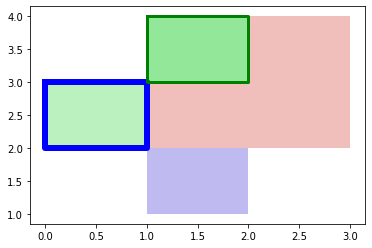

In [8]:
node = upper_left.df.iloc[2]
other_graph = upper_right

plot_identified_nodes(node, other_graph, identify_node(node, other_graph))

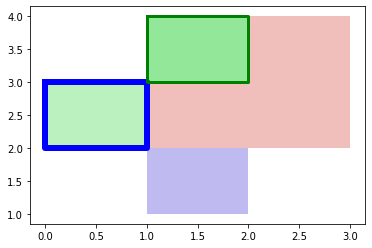

In [9]:
node = upper_left.df.iloc[2]
other_graph = upper_right

plot_identified_nodes(node, other_graph, identify_node_old(node, other_graph))

In [189]:
%%timeit
identify_node(node, other_graph)

1.52 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [222]:
%%timeit
identify_node_fast(node, other_graph)

439 µs ± 63.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [223]:
%%timeit
identify_node_fast(node, other_graph, mode="corner")

435 µs ± 103 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [224]:
%%timeit
identify_node_fast(node, other_graph, mode="edge")

575 µs ± 52 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [225]:
%%timeit
identify_node_fast(node, other_graph, mode="interior")

622 µs ± 107 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [10]:
%lprun -f identify_node identify_node(node, other_graph, mode="interior")

Timer unit: 1e-06 s

Total time: 0.006677 s
File: /home/users/svm/Code/gtc-biodiversity/src/models/binary_graph_operations.py
Function: identify_node at line 26

Line #      Hits         Time  Per Hit   % Time  Line Contents
    26                                           def identify_node(node: dict, other_graph: "GeoGraph", mode: str = "corner") -> ndarray:
    27                                               """
    28                                               Return list of all node ids in `other_graph` which identify with the given `node`.
    29                                           
    30                                               Args:
    31                                                   node (dict): The node for which to find nodes in `other_graphs` that can be
    32                                                       identified with `node`.
    33                                                   other_graph (GeoGraph): The GeoGraph object in which to sear

# Speedtests

In [9]:
geom = full.df.iloc[0]["geometry"]

In [120]:
from shapely.prepared import prep

## F1 Fast intersection checks (bulk)

In [142]:
from src.models.polygon_utils import de9im_match, CORNER_ONLY_PATTERN, EDGE_ONLY_PATTERN, OVERLAP_PATTERN

In [143]:
predicates = full.df.geometry.values[candidate_ids].relate(geom)

In [149]:
%%timeit
[de9im_match(predicate, CORNER_ONLY_PATTERN) for predicate in predicates]

5.83 µs ± 291 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [137]:
full.df.geometry.values[candidate_ids].relate(geom)

array(['2FFF1FFF2', 'FF2F11212', 'FF2F11212', 'FF2F01212'], dtype=object)

In [123]:
%%timeit
full.df.geometry.values[candidate_ids].relate(geom)

806 µs ± 57 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [124]:
%%timeit
full.df.geometry.values[candidate_ids].intersects(geom)

195 µs ± 13.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [125]:
%%timeit
prep(geom)
full.df.geometry.values[candidate_ids].relate(geom)

736 µs ± 26.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [126]:
%%timeit
prep(geom)
full.df.geometry.values[candidate_ids].intersects(geom)

255 µs ± 13.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## F2 Fastest geopandas access

Note: using the normal pandas indexing is incredibly slow for accessing the dataframe

In [76]:
%%timeit
full.df.loc[candidate_ids]

1.55 ms ± 569 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [75]:
%%timeit
full.df.iloc[candidate_ids]

1.07 ms ± 63.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Even if we only want to get one column of the dataframe

In [78]:
%%timeit
full.df.loc[candidate_ids, "class_label"]

738 µs ± 209 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [80]:
%%timeit
full.df.iloc[candidate_ids, 0]

342 µs ± 62.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Apparently there seems there is some sequential labelling going on

Instead, it's much faster to first select the colum and then the indices

In [81]:
%%timeit
full.df.class_label.values[candidate_ids]  # fastest for accessing class labels

9.46 µs ± 372 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [82]:
%%timeit
full.df.class_label.to_numpy()[candidate_ids]  

16.6 µs ± 3.39 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


For the geometry column in particular, it seems to matter whether we access via 
the pandas interface or the numpy interface

In [86]:
%%timeit
full.df.geometry[candidate_ids]

762 µs ± 120 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [88]:
%%timeit
full.df.geometry.to_numpy()[candidate_ids]

1.02 ms ± 76.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [87]:
%%timeit
full.df.geometry.values[candidate_ids]

38 µs ± 8.67 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


We can also access the geometries via the spatial index (rtree)

In [89]:
%%timeit
full.rtree.geometries[full.rtree.query(geom)] 

102 µs ± 9.72 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [91]:
%%timeit
full.rtree.geometries[candidate_ids] # fastest for accessing geometries

1.13 µs ± 182 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [37]:
candidate_ids = full.rtree.query(node["geometry"], sort=True)

In [38]:
%%timeit
candidates = full.df.to_numpy()[candidate_ids]  # assumes ids are continguous (no holes)

1.06 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [40]:
%%timeit
candidates = full.df.iloc[candidate_ids]

1.19 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## F3 Fast geopandas comparison

In [106]:
%%timeit
candidate_ids[full.df.class_label.values[candidate_ids] == 3]

15.3 µs ± 2.34 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [182]:
%%timeit
candidate_ids[np.where(other_graph.df.class_label.values[candidate_ids] == node["class_label"])]

22.1 µs ± 1.34 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## F4 Fastest RTree access

In [28]:
full.rtree.query(geom)

array([3, 0, 1, 4])

In [29]:
full.rtree.query(geom, predicate="intersects")

array([3, 0, 1, 4])

In [25]:
%%timeit
full.rtree.intersection(geom.bounds)

326 µs ± 93.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [26]:
%%timeit
full.rtree.query(geom, predicate="intersects")

132 µs ± 6.64 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [31]:
%%timeit
full.rtree.query(geom)

105 µs ± 17.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [30]:
%%timeit
full.rtree.query(geom, sort=True)

108 µs ± 13.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
